This is for learning the GAN model for generating pokemon images based on the Dive Into Deep Learning tutorial here:  https://d2l.ai/chapter_generative-adversarial-networks/dcgan.html

In [2]:
import torch
import torchvision
from torch import nn

In [3]:
import os
import requests
import zipfile

def download_and_extract_zip(url, directory_name):
    # Create the directory if it doesn't exist
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)

    # Download the zip file
    response = requests.get(url)
    zip_file_path = os.path.join(directory_name, 'temp.zip')
    with open(zip_file_path, 'wb') as f:
        f.write(response.content)

    # Extract the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(directory_name)

    # Delete the temporary zip file
    os.remove(zip_file_path)

    print('Download and extraction complete.')

url = 'http://d2l-data.s3-accelerate.amazonaws.com/pokemon.zip'
directory_name = 'data/pokemon'
download_and_extract_zip(url, directory_name)
pokemon = torchvision.datasets.ImageFolder(directory_name)

Download and extraction complete.


In [4]:
batch_size = 256
num_workers = 2
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])
pokemon.transform = transformer
data_iter = torch.utils.data.DataLoader(
    pokemon, batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

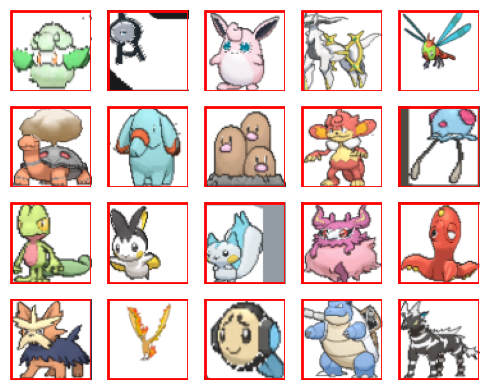

In [44]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from IPython.display import HTML

def visualize_images(images, num_rows, num_cols):
    _, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols, num_rows))
    plt.subplots_adjust(hspace=0.1, wspace=0.1)

    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * 5 + j
            ax = axes[i, j]
            ax.imshow(images[idx])
            ax.axis('off')
            rect = patches.Rectangle((0, 0), 63, 63, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

    plt.tight_layout()
    plt.show()

for X, y in data_iter:
    visualize_images(X[:20, :, :, :].permute(0, 2, 3, 1) / 2 + 0.5, 4, 5)
    break

In [6]:
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2, padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In [7]:
x = torch.zeros((2, 3, 16, 16))
g_blk = G_block(20)
g_blk(x).shape

torch.Size([2, 20, 32, 32])

In [8]:
n_G = 64
net_G = nn.Sequential(
    G_block(in_channels=100, out_channels=n_G*8, strides=1, padding=0),
    G_block(in_channels=n_G*8, out_channels=n_G*4),                         # Output: (64 * 8, 4, 4)
    G_block(in_channels=n_G*4, out_channels=n_G*2),                         # Output: (64 * 4, 8, 8)
    G_block(in_channels=n_G*2, out_channels=n_G),                           # Output: (64, 32, 32)
    nn.ConvTranspose2d(in_channels=n_G, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()                                                               # Output: (3, 64, 64)
)

In [9]:
x = torch.zeros((1, 100, 1, 1))
net_G(x).shape

torch.Size([1, 3, 64, 64])

In [10]:
class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2, padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)
    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

In [11]:
x = torch.zeros((2, 3, 16, 16))
d_blk = D_block(20)
d_blk(x).shape

torch.Size([2, 20, 8, 8])

In [12]:
n_D = 64
net_D = nn.Sequential(
    D_block(n_D),                                                                   # Output: (64, 32, 32)
    D_block(in_channels=n_D, out_channels=n_D*2),                                   # Output: (64 * 2, 16, 16)
    D_block(in_channels=n_D*2, out_channels=n_D*4),                                 # Output: (64 * 4, 8, 8)
    D_block(in_channels=n_D*4, out_channels=n_D*8),                                 # Output: (64 * 8, 4, 4)
    nn.Conv2d(in_channels=n_D*8, out_channels=1, kernel_size=4, bias=False)         # Output: (1, 1, 1)
)

In [13]:
x = torch.zeros((1, 3, 64, 64))
net_D(x).shape

torch.Size([1, 1, 1, 1])

In [14]:
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    batch_size = X.shape[0]
    ones = torch.ones((batch_size,), device=X.device)
    zeros = torch.zeros((batch_size,), device=X.device)
    trainer_D.zero_grad()
    real_Y = net_D(X)
    fake_X = net_G(Z)
    fake_Y = net_D(fake_X.detach())
    loss_D = (loss(real_Y, ones.reshape(real_Y.shape)) + loss(fake_Y, zeros.reshape(fake_Y.shape))) / 2
    loss_D.backward()
    trainer_D.step()
    return loss_D

In [15]:
def update_G(Z, net_D, net_G, loss, trainer_G):
    batch_size = Z.shape[0]
    ones = torch.ones((batch_size,), device=Z.device)
    trainer_G.zero_grad()
    fake_X = net_G(Z)
    fake_Y = net_D(fake_X)
    loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
    loss_G.backward()
    trainer_G.step()
    return loss_G

In [72]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim, device='cuda'):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    net_D, net_G = net_D.to(device), net_G.to(device)
    trainer_hp = {'lr': lr, 'betas': [0.5, 0.999]}
    trainer_D = torch.optim.Adam(net_D.parameters(), **trainer_hp)
    trainer_G = torch.optim.Adam(net_G.parameters(), **trainer_hp)
    fake_x_history = []
    total_loss_D_history, total_loss_G_history = [], []
    for epoch in range(1, num_epochs + 1):
        total_loss_D, total_loss_G, total_cnt = 0, 0, 0
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.to(device), Z.to(device)
            loss_D = update_D(X, Z, net_D, net_G, loss, trainer_D)
            loss_G = update_G(Z, net_D, net_G, loss, trainer_G)
            total_loss_D += loss_D.item()
            total_loss_G += loss_G.item()
            total_cnt += batch_size
        Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1), device=device)
        fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
        fake_x_history.append(fake_x.detach().cpu().numpy())
        total_loss_D_history.append(total_loss_D / total_cnt)
        total_loss_G_history.append(total_loss_G / total_cnt)
    
    line_D, = plt.plot(range(num_epochs), total_loss_D_history, label='loss D')
    line_G, = plt.plot(range(num_epochs), total_loss_G_history, label='loss G')
    plt.legend(handles=[line_D, line_G], labels=['loss D', 'loss G'])
    plt.show()
    plt.close()

    num_rows, num_cols = 3, 7
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols, num_rows))
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    def _update(frame):
        plt.cla()
        for i in range(num_rows):
            for j in range(num_cols):
                idx = i * 5 + j
                ax = axes[i, j]
                ax.imshow(fake_x_history[frame][idx])
                ax.axis('off')
                rect = patches.Rectangle((0, 0), 63, 63, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

    plt.tight_layout()
    return animation.FuncAnimation(fig, _update, frames=len(fake_x_history), interval=200, repeat=False)

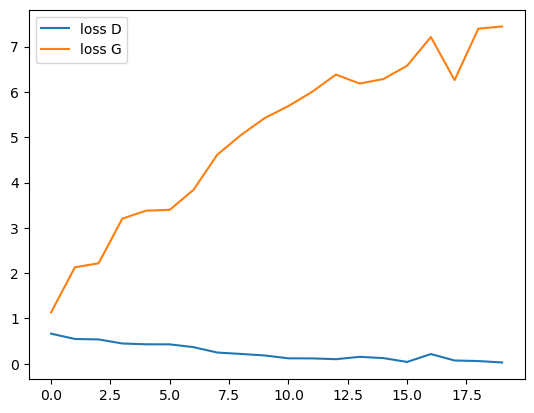

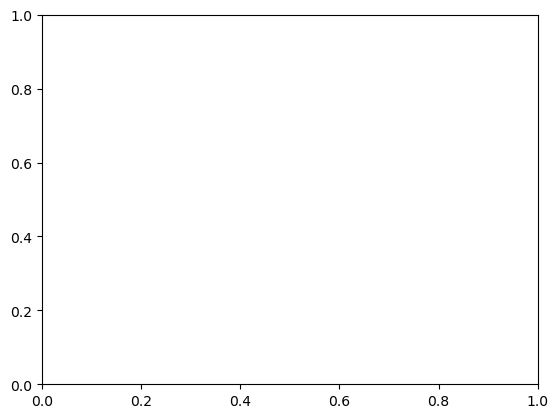

In [73]:
latent_dim, lr, num_epochs = 100, 0.005, 20
ani = train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)
plt.close()
HTML(ani.to_jshtml())